**Problem Description:**

The challenge is a binary image classification task aimed at detecting metastatic cancer in small image patches extracted from larger digital pathology scans. Specifically, the goal is to develop an algorithm that can accurately classify these patches as either containing metastatic cancer (positive label) or not (negative label). The presence of cancer is determined solely by the presence of tumor tissue within the center 32x32 pixel region of each patch. This task has significant clinical relevance, as it directly addresses the critical issue of cancer metastasis detection.

**Data Description:**

The dataset is a modified version of the PatchCamelyon (PCam) benchmark dataset. It consists of a large number of small, color pathology images. Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.

-   **Size:** The dataset comprises thousands of image patches, split into training and testing sets.
-   **Dimension:** Each image patch has a fixed dimension of 96x96 pixels with 3 color channels (RGB).
-   **Structure:**
    -   The data (which is all stored in `data/`) is organized into two subdirectories: `train/` and `test/`.
    -   The `train` folder contains images for training the model, and the `test` folder contains images for which predictions are to be made.
    -   A `train_labels.csv` file provides the ground truth labels for the training images, mapping image IDs to binary labels (0 or 1).
    -   The labels are only determined by the center 32x32 pixel region of each image.
    -   The outer area of the 96x96 images are provided to support fully convolutional network architectures.
-   **Format:** Images are in standard image formats (tif).
-   **Class Imbalance:** It's important to note that the dataset exhibits class imbalance, with an unequal distribution of positive and negative samples.
-   **No Duplicates:** The Kaggle version of the PCam dataset has been processed to remove duplicate images, ensuring a cleaner training set.

In [143]:
# --- Standard Libraries ---
import os
import io

# --- Data Manipulation & Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Image Processing & Augmentation ---
import cv2
import albumentations as A  # Efficient augmentations
from albumentations.pytorch import ToTensorV2  # Optional for conversion

# --- TensorFlow & Deep Learning ---
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from tensorflow.keras.applications import ResNet50, EfficientNetB3  # Backbones
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense,
                                    Dropout, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Legacy loader
from tensorflow.keras import backend as K

# --- Hyperparameter Tuning & Utilities ---
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image, UnidentifiedImageError
from keras_tuner import HyperParameters as hp

In [144]:
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.18.0
GPU Available: []


In [145]:
# Load labels and check dataset size
train_labels = pd.read_csv('data/train_labels.csv')
train_dir = 'data/train'
print(f"Total training samples: {len(train_labels)}")
print(f"Test directory file count: {len(os.listdir('data/test'))}")  # Verify test size

Total training samples: 220025
Test directory file count: 57458


In [146]:
# Display the first few rows of the labels
print(train_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


/var/folders/mz/8ggffgss3v39bd1rmk8kb1sh0000gr/T/ipykernel_18596/3085082469.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=train_labels, palette='viridis')


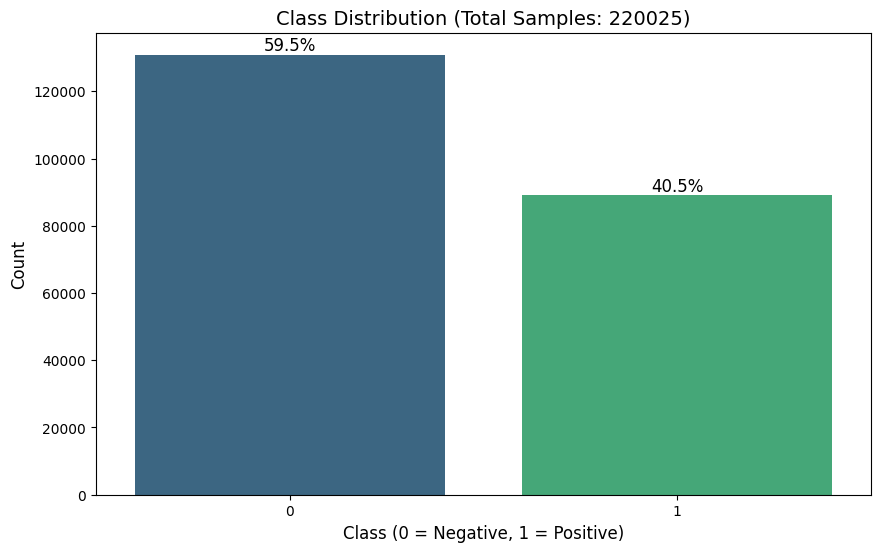

In [147]:
# Class distribution analysis
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=train_labels, palette='viridis')

# Add percentages to the plot
total = len(train_labels)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.title(f'Class Distribution (Total Samples: {total})', fontsize=14)
plt.xlabel('Class (0 = Negative, 1 = Positive)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [148]:
# Numerical summary
class_counts = train_labels['label'].value_counts()
print(f"Class 0 (Negative): {class_counts[0]} samples ({class_counts[0]/total:.1%})")
print(f"Class 1 (Positive): {class_counts[1]} samples ({class_counts[1]/total:.1%})")

Class 0 (Negative): 130908 samples (59.5%)
Class 1 (Positive): 89117 samples (40.5%)


In [149]:
# Get positive & negative samples
num_samples = 5
positive_samples = train_labels[train_labels['label'] == 1].sample(n=num_samples, random_state=42)
negative_samples = train_labels[train_labels['label'] == 0].sample(n=num_samples, random_state=42)

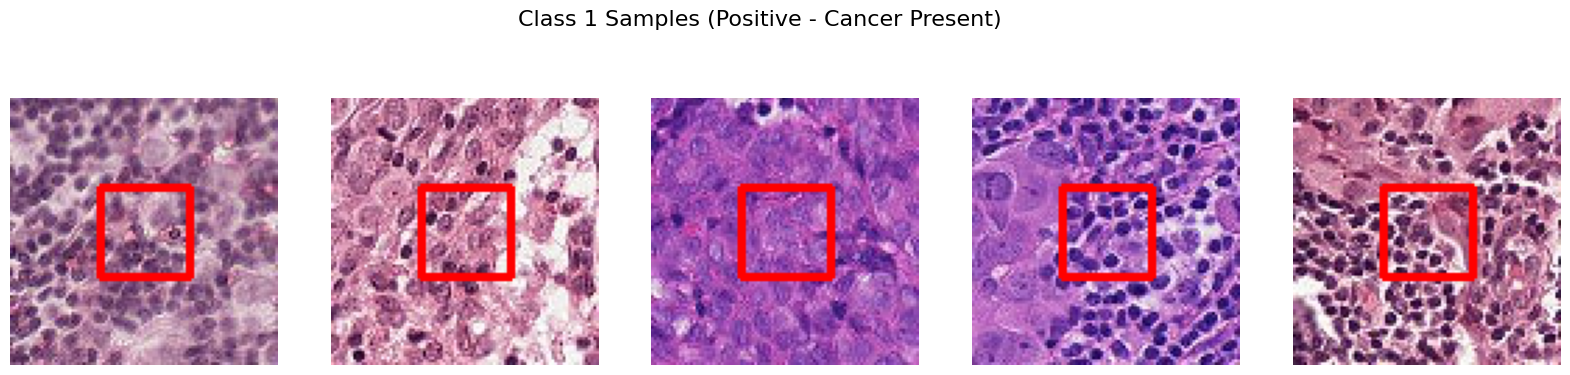

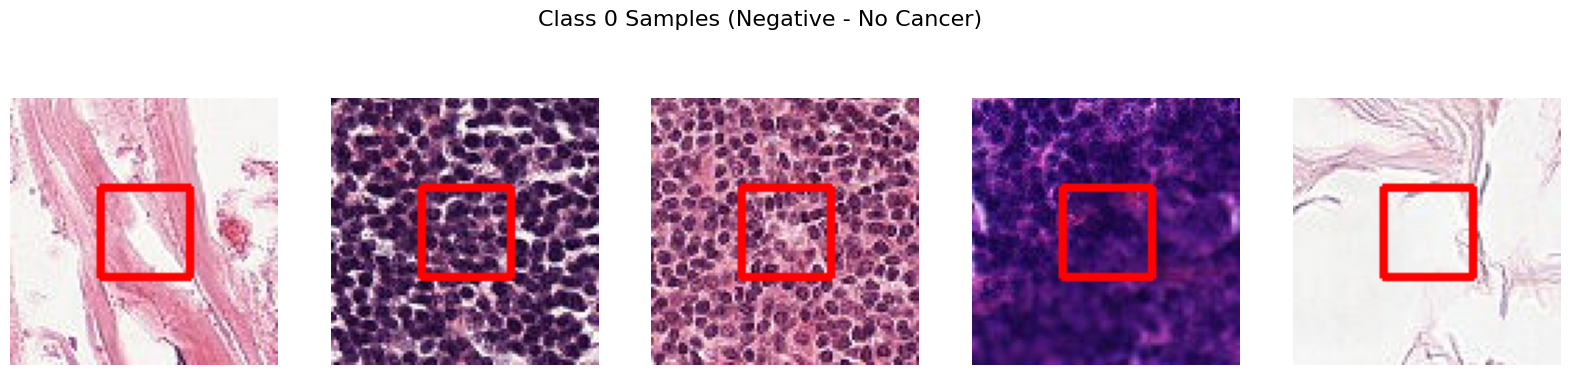

In [150]:
# Function to plot samples with center region highlighted
def plot_class_samples(df, class_label, num_samples=5, title_suffix=""):
    samples = df[df['label'] == class_label].sample(n=num_samples, random_state=42)
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    fig.suptitle(f"Class {class_label} Samples {title_suffix}", y=1.05, fontsize=16)

    for ax, (idx, row) in zip(axes, samples.iterrows()):
        img = cv2.imread(os.path.join(train_dir, row['id'] + '.tif'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Highlight center region
        cv2.rectangle(img, (32, 32), (64, 64), (255, 0, 0), 2)  # Red rectangle

        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Plot both classes with consistent formatting
plot_class_samples(train_labels, 1, title_suffix="(Positive - Cancer Present)")
plot_class_samples(train_labels, 0, title_suffix="(Negative - No Cancer)")

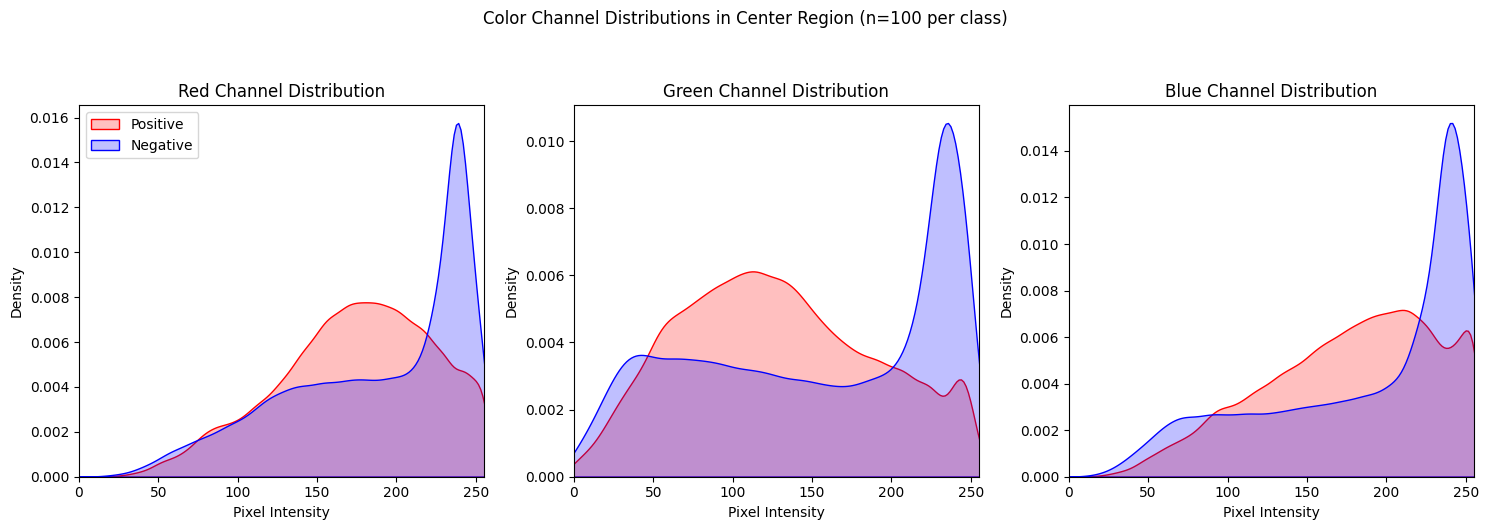

In [151]:
def compare_class_color_distributions(num_samples=100):
    plt.figure(figsize=(15, 5))

    # Sample images from both classes
    pos_samples = train_labels[train_labels['label'] == 1].sample(num_samples)
    neg_samples = train_labels[train_labels['label'] == 0].sample(num_samples)

    # Load and process images
    def get_center_pixels(samples):
        pixels = []
        for _, row in samples.iterrows():
            img = cv2.imread(os.path.join(train_dir, row['id'] + '.tif'))
            center_region = img[32:64, 32:64]  # Focus on diagnostic area
            pixels.append(center_region.reshape(-1, 3))
        return np.vstack(pixels)

    pos_pixels = get_center_pixels(pos_samples)
    neg_pixels = get_center_pixels(neg_samples)

    # Plot distributions
    channels = ['Red', 'Green', 'Blue']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        sns.kdeplot(pos_pixels[:, i], color='r', label='Positive', fill=True)
        sns.kdeplot(neg_pixels[:, i], color='b', label='Negative', fill=True)
        plt.title(f'{channels[i]} Channel Distribution')
        plt.xlabel('Pixel Intensity')
        plt.xlim(0, 255)
        if i == 0: plt.legend()

    plt.suptitle("Color Channel Distributions in Center Region (n=100 per class)", y=1.05)
    plt.tight_layout()
    plt.show()

compare_class_color_distributions()

In [152]:
# Calculate class weights for loss function

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels['label']),
    y=train_labels['label'].values
)
class_weights = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights}")

Class Weights: {0: 0.840380267057781, 1: 1.234472659537462}


In [153]:
# Split data into train/validation
train_df, val_df = train_test_split(
    train_labels,
    test_size=0.2,
    stratify=train_labels['label'],  # Preserve class balance
    random_state=42
)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Train size: 176020, Validation size: 44005


In [154]:
# Verify stratified split
def check_split_distribution(train_df, val_df):
    train_ratio = train_df['label'].mean()
    val_ratio = val_df['label'].mean()
    orig_ratio = train_labels['label'].mean()

    print(f"Original positive ratio: {orig_ratio:.4f}")
    print(f"Train positive ratio:    {train_ratio:.4f}")
    print(f"Val positive ratio:      {val_ratio:.4f}")

    assert np.isclose(train_ratio, orig_ratio, atol=0.005), "Train split not stratified!"
    assert np.isclose(val_ratio, orig_ratio, atol=0.005), "Val split not stratified!"

check_split_distribution(train_df, val_df)

Original positive ratio: 0.4050
Train positive ratio:    0.4050
Val positive ratio:      0.4050


In [155]:
def create_dataset(df, augment=False):
    """Create optimized TF Dataset for TIFF images"""
    image_paths = df['id'].apply(lambda x: f"data/train/{x}.tif").tolist()
    labels = df['label'].values.astype(np.float32)
    
    # Create dataset from slices
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    def parse_image(path, label):
        """Read and decode TIFF image"""
        img_bytes = tf.io.read_file(path)
        try:
            # Use PIL to decode TIFF
            image = tf.py_function(
                lambda x: np.array(Image.open(io.BytesIO(x.numpy())).convert('RGB')),
                [img_bytes],
                tf.uint8
            )
            image = tf.ensure_shape(image, (96, 96, 3))
            return image, label
        except:
            print(f"Error reading {path}, skipping")
            return tf.zeros([96, 96, 3], dtype=tf.uint8), label
    
    def preprocess(image, label):
        """Standard preprocessing"""
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.per_image_standardization(image)
        return image, label
    
    # Map with proper argument handling
    dataset = dataset.map(
        lambda p, l: tf.py_function(parse_image, [p, l], [tf.uint8, tf.float32]),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        def augment_fn(image, label):
            """Augmentation pipeline"""
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, 0.1)
            image = tf.image.random_contrast(image, 0.9, 1.1)
            return image, label
        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset.batch(64).prefetch(2)

# Create datasets
train_ds = create_dataset(train_df, augment=True)
val_ds = create_dataset(val_df)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.971328..0.9979307].


Image batch shape: (64, 96, 96, 3)
Label batch shape: (64,)


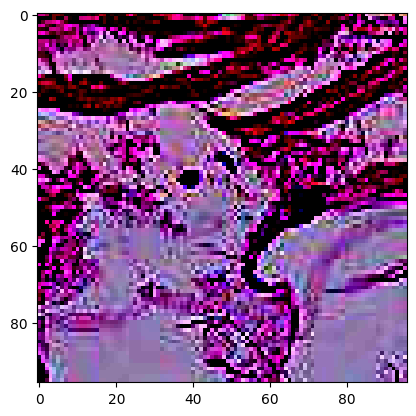

In [156]:
# Check first batch
sample_images, sample_labels = next(iter(train_ds))
print(f"Image batch shape: {sample_images.shape}")  # Should be (64, 96, 96, 3)
print(f"Label batch shape: {sample_labels.shape}")  # Should be (64,)

# Visualize sample
plt.imshow(sample_images[0].numpy().astype('float32'))
plt.show()

In [157]:
# Select a sample of IDs (here, the first 10)
sample_ids = train_df['id'].head(10).tolist()

# Construct full file paths and check if they exist
for img_id in sample_ids:
    path = f"data/train/{img_id}.tif"
    exists = tf.io.gfile.exists(path)
    print(f"File path: {path} exists: {exists}")

File path: data/train/cffe7a3ffc48700045fd37f1f448b5a892ff4f2c.tif exists: True
File path: data/train/b5bef3e7d7e8cc81e38fa2288105fc1c130e771a.tif exists: True
File path: data/train/6fe4413a3a982af28a6e78d0f445073c509b4b33.tif exists: True
File path: data/train/d6b4fe580210f5ea61b7c109b5c2e5cc734c3010.tif exists: True
File path: data/train/1b6b051e370ca8468253d2e40f686c66eecb1619.tif exists: True
File path: data/train/161a3685624448cb26d6d36cdbe7744d735d34a8.tif exists: True
File path: data/train/50f1da97486b41cc774f99d57c2560d02ce75678.tif exists: True
File path: data/train/234c88b0c547bc1975da9abb8cd74cd89ed54c5a.tif exists: True
File path: data/train/f61d67a31b652cd928ef94e36ff3fb1db707f06f.tif exists: True
File path: data/train/ed5a70aba921910d1af57a8e468c7b90036eeb99.tif exists: True


In [158]:
# Choose a sample file path
sample_path = f"data/train/{sample_ids[0]}.tif"

# Read the file contents
img_bytes = tf.io.read_file(sample_path)

# Convert tensor to bytes (using .numpy() because we're in eager mode)
img_bytes = img_bytes.numpy()

try:
    # Attempt to load the image with PIL
    img = Image.open(io.BytesIO(img_bytes))
    # Convert to RGB (in case it's in a different mode)
    img = img.convert("RGB")
    # Convert to a NumPy array
    img_arr = np.array(img, dtype=np.uint8)
    print("Image loaded successfully with shape:", img_arr.shape)
except Exception as e:
    print("Error loading image:", e)

Image loaded successfully with shape: (96, 96, 3)


In [159]:
for images, labels in train_ds.take(1):
    print("Batch image shape:", images.shape)
    print("Batch labels shape:", labels.shape)


Batch image shape: (64, 96, 96, 3)
Batch labels shape: (64,)
